<a href="https://colab.research.google.com/github/demyanchuk-nestor/AI_for_Medical_Diagnosis/blob/main/29_Застосування_машинного_навчання_для_виявлення_захворювань_на_основі_аналізу_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Застосування машинного навчання для виявлення захворювань на основі аналізу Електрокардіограм
Типовим завданням прикладного машинного навчання в медицині є автоматична класифікація сигналів від діагностичних пристроїв, таких як ЕКГ або ЕЕГ.

Типова послідовність:
- виявити комплекси QRS
- класифікувати їх:
> - оцінка за нормальністю зубець N
> - аритмія, наприклад, *шлуночкова* V, *надшлуночкова* S аритмія або *мерехтіння передсердь* AF


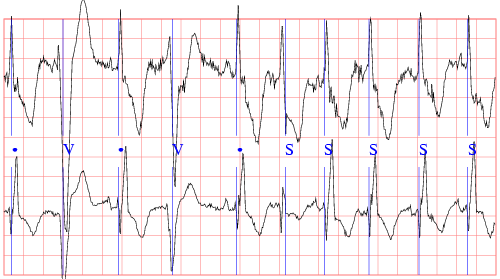

![ECG signal](https://ars.els-cdn.com/content/image/1-s2.0-S0950705120307188-gr1.jpg)

декілька посилань:
- набори ЕКГ з Physionet (https://physionet.org/content/challenge-2017/1.0.0/)
- - приклад статті по класифікації ECG (https://doi.org/10.1016/j.knosys.2020.106589)

## Наше завдання: класифікувати ЕКГ як нормальні або ненормальні (аритмія)
- ми будемо використовувати сигнали з бази даних **svdb**, проводити їх попередню обробку
- буде проведено підготовку наборів даних
- потім побудуємо бінарні класифікатори, використовуючи дерева рішень, ансамблеві методи, SVM або NaiveBayes методи
- проведемо оцінку побудованих класифікаційних моделей, шляхом оцінки величини показників Загальна точності, Acc_T та Точності прогнозу за класом Аритмії, Acc_A  
- проведемо підбір показників  для досягнення максимальної якості класифікаційної моделі Дерев рішень (DT), максимальної Загальна точності, Acc_T та максимальної Точності прогнозу за класом Аритмії, Acc_A, шляхом підбору кількості шарів дерев рішення (max_depth) в інтервалі від (1 до 50).   

## Підготовка наборів даних
1. Завантажуються записи ЕКГ з бази даних **svdb**, наданої *PhysioNet*.
2. Розділяються сигнали на відліки, кожен з яких містить одне серцеве скорочення (з розміром вікна 96 точок, *частота дискретизації* = 128 точок/с)
3. Обираються тільки зразки, позначені як "N" (нормальний ритм), або "S" і "V" (аритмії).

In [1]:
import os
import numpy as np

# Встановлення бібліотеки для роботи з базами даних PhysioNet
!pip install wfdb
import wfdb

# Отримання переліку доступних наборів даних
dbs = wfdb.get_dbs()
display(dbs)

# Завантажуємо набір даних "svdb"
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')
wfdb.dl_database('svdb', dl_dir=svdb_dir)

# Відображення завантажених файлів
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['actes-cycloergometer-exercise',
  'Cardiorespiratory measurement from graded cycloergometer exercise testing'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-opioid-use-notes',
  'Annotation dataset of problematic opioid use and related contexts from MIMIC-III Critical Care Database discharge summaries'],
 ['antimicrobial-resistance-uti',
  'AMR

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

In [2]:
# Компонування сигналів із завантажених файлів у загальний набір даних (датасет)
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-64,position+64] window
    beats = np.zeros((len(annotations.sample),time_window*2))
    # note that we remove first and last beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove few first and last annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# Відбір сигналів ЕКГ з мітками клаcів "N", "S" та "V"
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V'}]

all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# Вивід інформації
print(all_beats.shape, all_annotations.shape)

...processing...800...file
...processing...801...file
...processing...802...file
...processing...803...file
...processing...804...file
...processing...805...file
...processing...806...file
...processing...807...file
...processing...808...file
...processing...809...file
...processing...810...file
...processing...811...file
...processing...812...file
...processing...820...file
...processing...821...file
...processing...822...file
...processing...823...file
...processing...824...file
...processing...825...file
...processing...826...file
...processing...827...file
...processing...828...file
...processing...829...file
...processing...840...file
...processing...841...file
...processing...842...file
...processing...843...file
...processing...844...file
...processing...845...file
...processing...846...file
...processing...847...file
...processing...848...file
...processing...849...file
...processing...850...file
...processing...851...file
...processing...852...file
...processing...853...file
.

In [3]:
# Вивід розподілів за класами "N" (нормальний ритм), "S" і "V" (аритмії)
from collections import Counter

class_dist = Counter(all_annotations)
print('Розподіл за класами захворювань (N / S / V) в загальному наборі даних:')
for i in class_dist:
    print('Клас {}: кількість представників - {}'.format(i, class_dist[i]))

Розподіл за класами захворювань (N / S / V) в загальному наборі даних:
Клас N: кількість представників - 161653
Клас S: кількість представників - 12146
Клас V: кількість представників - 9908


### Візуалізація сигналів за класами захворювань

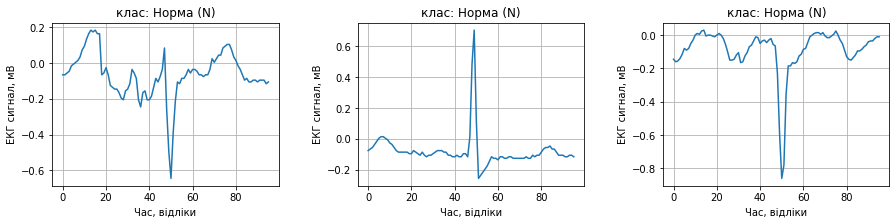

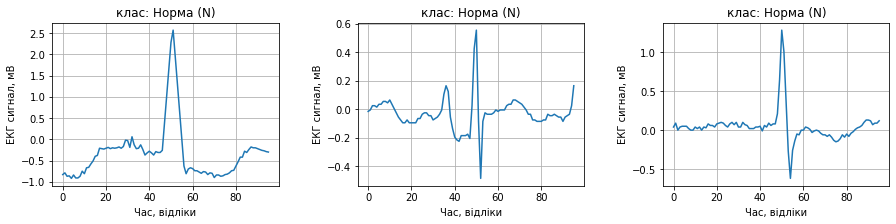

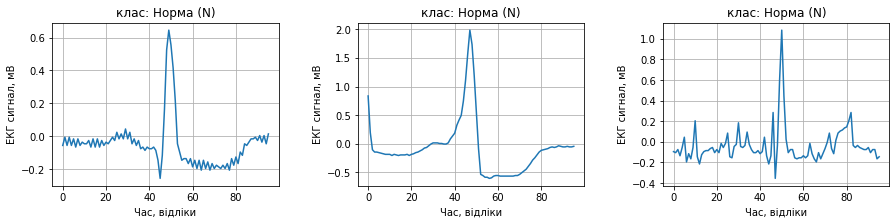

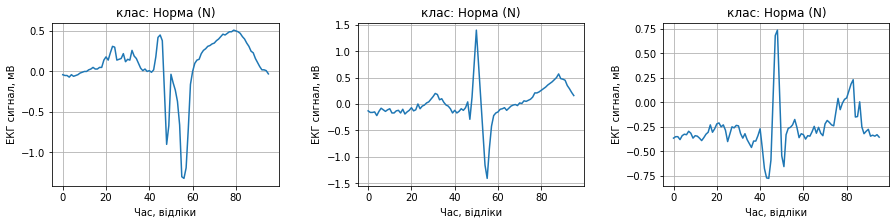

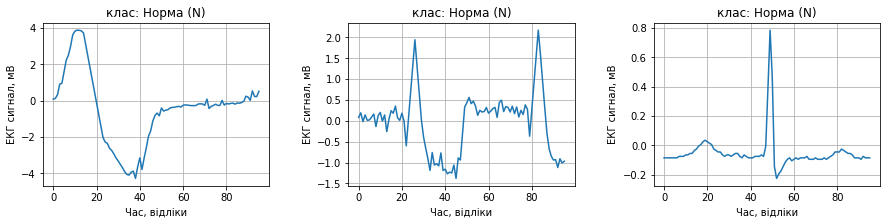

In [4]:
from sklearn.utils.random import sample_without_replacement
import matplotlib.pyplot as plt

# Виберемо випадковим чином 15 сигналів, що належать до класу N" (нормальний ритм) для відображення 
number_of_samples = 15
n_idx = np.where(all_annotations=='N')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів на графіках
for i in range(5):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    for j, sn in enumerate(sample_number[i,:]):
        ax[j].plot(all_beats[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='клас: Норма ' + '(' + all_annotations[sn] + ')')
        ax[j].grid()
    plt.show()

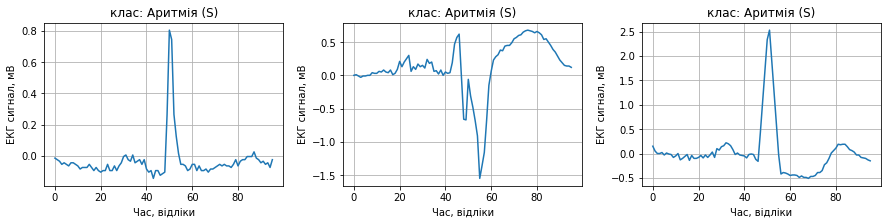

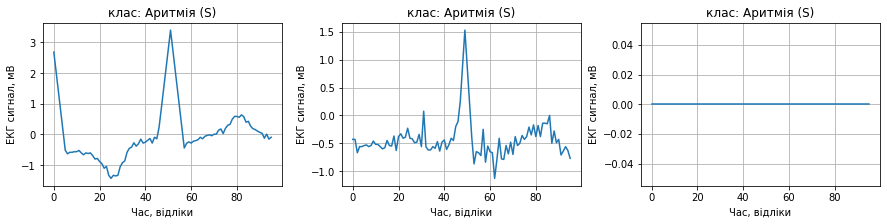

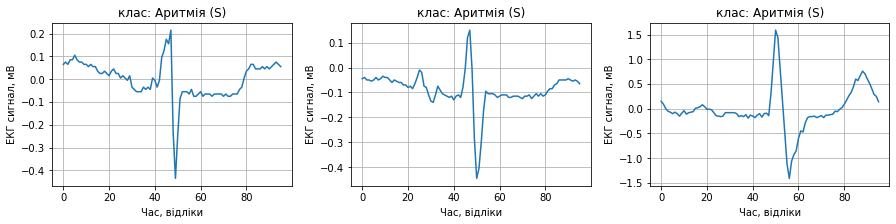

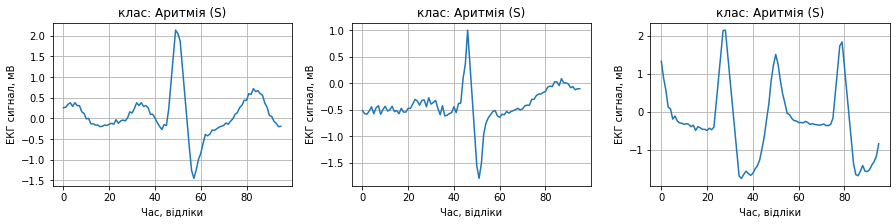

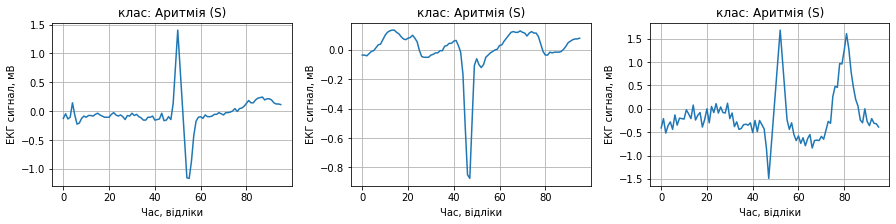

In [5]:
# Виберемо випадковим чином 15 сигналів, що належать до класу "S" (аритмія) для відображення 
number_of_samples = 15
n_idx = np.where(all_annotations=='S')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів на графіках
for i in range(5):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    for j, sn in enumerate(sample_number[i,:]):
        ax[j].plot(all_beats[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='клас: Аритмія ' + '(' + all_annotations[sn] + ')')
        ax[j].grid()
    plt.show()

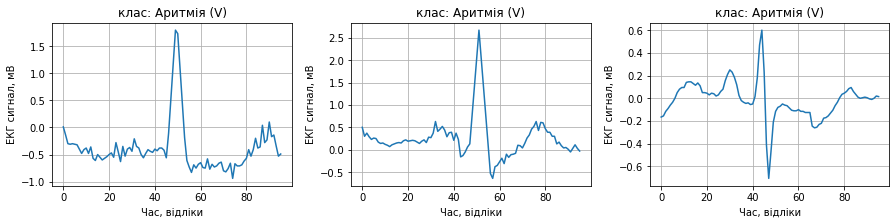

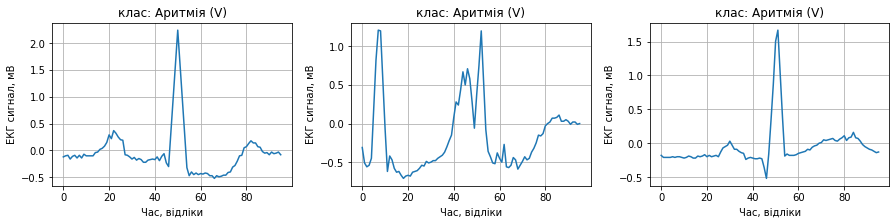

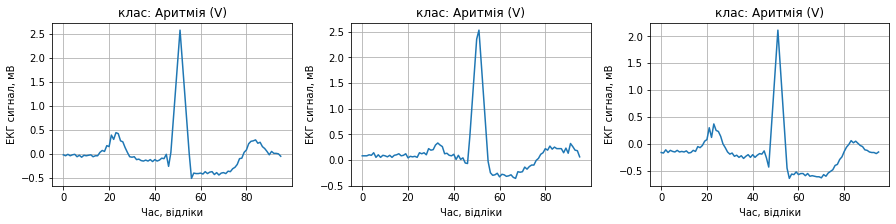

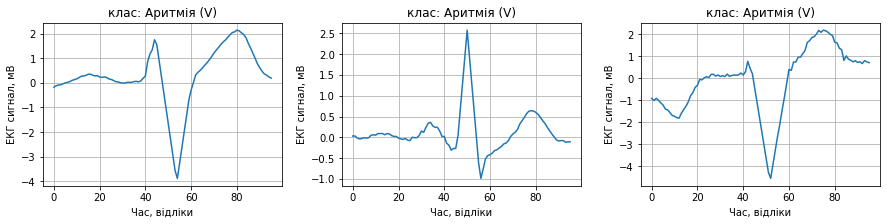

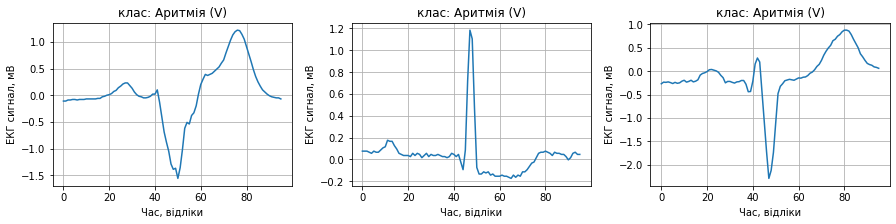

In [6]:
# Виберемо випадковим чином 15 сигналів, що належать до класу "V" (аритмія) для відображення 
number_of_samples = 15
n_idx = np.where(all_annotations=='V')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів на графіках
for i in range(5):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    for j, sn in enumerate(sample_number[i,:]):
        ax[j].plot(all_beats[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='клас: Аритмія ' + '(' + all_annotations[sn] + ')')
        ax[j].grid()
    plt.show()

## Експеримент 1

0. Підготовка
> Набори даних діляться на навчальну, валідаційну та тестову підмножини та проводиться їх нормалізація кожної з них.
> Визначте метрики точності класифікації (набір даних незбалансований). Оцініть значення Загальна точності, Acc_T та Точності прогнозу за класом Аритмії, Acc_A. Найбільше значення обох метрик вказують на найкраще побудовану модель з найвищою точністю.
>> Матриця розбіжностей
```
____Prediction
T |   n  s  v
r |N  Nn Ns Nv
u |S  Sn Ss Sv
t |V  Vn Vs Vv
h |
```
Нижче наведено алгоритм розрахунку точності Загальна точності, Acc_T та Точності прогнозу за класом Аритмії, Acc_A.
>> - Total accuracy
$Acc_T = \frac{Nn+Ss+Vv}{\Sigma_N+\Sigma_S+\Sigma_V}$,
>> - Arrhythmia accuracy (S or V cases are more important to be detected):
$Acc_A = \frac{Ss+Vv}{\Sigma_S+\Sigma_V}$,
>> - $\Sigma_N=Nn+Ns+Nv$, $\Sigma_S=Sn+Ss+Sv$,
$\Sigma_V=Vn+Vs+Vv$



Показники Загальна точності, Acc_T та Точності прогнозу за класом Аритмії, Acc_A  будуть використані для оцінки якості наступних алгоритмів:
1. Базові класифікатори: *naive Bayes* та *SVM*.
2. Дерево рішень з початковою та оптимально визначеною глибиною

In [7]:
# Підготовка наборів даних та визначення критеріїв оцінки якості моделей 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Для прискорення процесу навчання, візьмемо лише частину даних з датасету (кожний п'ятий елемент)
X, y = all_beats[::5], all_annotations[::5]

# Формування навчального (X_train, y_train), тестового (X_test, y_test) та валідаційного (X_val, y_val) набору даних
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)

In [8]:
# Вивід обсягів наборів даних (об'ємів вибірки)
print('Обсяг навчального набору даних: {} елементів'.format(len(y_train)))
print('Обсяг валідаційного набору даних: {} елементів'.format(len(y_val)))
print('Обсяг тестового набору даних: {} елементів'.format(len(y_test)))

Обсяг навчального набору даних: 25718 елементів
Обсяг валідаційного набору даних: 5512 елементів
Обсяг тестового набору даних: 5512 елементів


In [9]:
# Вивід розподілів за класами "N" (нормальний ритм), "S" і "V" (аритмії)
train_class_dist = Counter(y_train)
print('Розподіл за класами захворювань (N / S / V) в навчальному наборі даних:')
for i in train_class_dist:
    print('Клас {}: кількість представників - {}'.format(i, train_class_dist[i]))

Розподіл за класами захворювань (N / S / V) в навчальному наборі даних:
Клас S: кількість представників - 1672
Клас N: кількість представників - 22704
Клас V: кількість представників - 1342


In [10]:
val_class_dist = Counter(y_val)
print('Розподіл за класами захворювань (N / S / V) в валідаційному наборі даних:')
for i in val_class_dist:
    print('Клас {}: кількість представників - {}'.format(i, val_class_dist[i]))

Розподіл за класами захворювань (N / S / V) в валідаційному наборі даних:
Клас N: кількість представників - 4827
Клас S: кількість представників - 363
Клас V: кількість представників - 322


In [11]:
test_class_dist = Counter(y_test)
print('Розподіл за класами захворювань (N / S / V) в тестовому наборі даних:')
for i in test_class_dist:
    print('Клас {}: кількість представників - {}'.format(i, test_class_dist[i]))

Розподіл за класами захворювань (N / S / V) в тестовому наборі даних:
Клас N: кількість представників - 4820
Клас V: кількість представників - 294
Клас S: кількість представників - 398


In [12]:
# Нормалізація даних: z = (x - u)/s для навчальної вибірки
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Нормалізація даних для валідаційної вибірки
X_val = preprocessing.StandardScaler().fit_transform(X_val)

# Нормалізація даних для тестової вибірки
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# Визначення алгоритму розрахунку метрики якості класифікації (в даному випадку - точності)
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')
        print(comment)
        print('Загальна точність, Acc_T = {:.4f}'.format(acc_t))
        print('Точність прогнозу за класом Аритмії, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a

### Створення / навчання базових моделей

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

# Ініціалізація моделі Gaussian Naive Bayes
gnb = GaussianNB()

# Навчання моделі на навчальному наборі даних (X_train, y_train)
gnb.fit(X_train, y_train)

# Отримання прогнозів (класів захворювань) за тестовим набором даних (X_test)
y_pred = gnb.predict(X_test)

# Оцінка якості моделі за тестовим набором даних (y_test)
calculate_accuracy(y_pred, y_test, comment='naive Bayes classifier')

-----------------------------------
naive Bayes classifier
Загальна точність, Acc_T = 0.7678
Точність прогнозу за класом Аритмії, Acc_A = 0.1445
-----------------------------------


In [14]:
# Ініціалізація моделі C-Support Vector Classification
svc = svm.SVC()

# Навчання моделі на навчальному наборі даних (X_train, y_train)
svc.fit(X_train, y_train)

# Отримання прогнозів (класів захворювань) за тестовим набором даних (X_test)
y_pred = svc.predict(X_test)

# Оцінка якості моделі за тестовим набором даних (y_test)
calculate_accuracy(y_pred, y_test, comment='SVM classifier')

-----------------------------------
SVM classifier
Загальна точність, Acc_T = 0.8806
Точність прогнозу за класом Аритмії, Acc_A = 0.0549
-----------------------------------


In [15]:
# Ініціалізація моделі C-Support Vector Classification (з балансуванням даних)
svc = svm.SVC(class_weight='balanced')

# Навчання моделі на навчальному наборі даних (X_train, y_train)
svc.fit(X_train, y_train)

# Отримання прогнозів (класів захворювань) за тестовим набором даних (X_test)
y_pred = svc.predict(X_test)

# Оцінка якості моделі за тестовим набором даних (y_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

-----------------------------------
balanced SVM classifier
Загальна точність, Acc_T = 0.6406
Точність прогнозу за класом Аритмії, Acc_A = 0.4899
-----------------------------------


Підсумок цієї частини:
1. В цій частині побудованоо 3 класифікаційних алгоритми при допопмозі naive Bayes, SVM та збалансованого (узгодженими наборами даних) SVM. Мета полягає в тому, щоб максимізувати обидві метрики Acc_T та Acc_A одночасно
1. naive Bayes працює досить погано
> - проблема з дисбалансом даних
2. SVM має схожу проблему, але після вирівнювання даних працює досить добре

### Створення / навчання моделей на основі дерев прийняття рішень 

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Ініціалізація моделі Decision Tree Classifier (з балансуванням даних)
dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10)

# Навчання моделі на навчальному наборі даних (X_train, y_train)
dtc.fit(X_train, y_train)

# Отримання прогнозів (класів захворювань) за тестовим набором даних (X_test)
y_pred = dtc.predict(X_test)

# Оцінка якості моделі за тестовим набором даних (y_test)
calculate_accuracy(y_pred, y_test, comment='balanced DT')

-----------------------------------
balanced DT
Загальна точність, Acc_T = 0.6382
Точність прогнозу за класом Аритмії, Acc_A = 0.3367
-----------------------------------


In [17]:
# Спроба покращення моделі, шляхом оптимізації одного з її гіперпараметрів,
# зокрема - глибини дерева (числа рівнів/ярусів): max_depth
# Занадто великі значення цього показника можуть призвести до формування великої за розміром моделі, 
# зробити її обчислювально складною, а також призвести до виникнення ефекту "перенавчання".
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []

# Задаємо діапазон значень глибини дерева
depth_range = range(1,26)  # [1,2,3,...,25]

# Спробуємо знайти оптимальне значення параметру max_depth з заданого діапазону, при якому буде досягнуто найвище значення
# обраної метрики оцінки якості моделі (в нашому випадку - точності / accuracy)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy',
                                 class_weight='balanced',
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print('Глибина дерева: {} | Точність (аритмія, валідаційний набір): {}'.format(max_depth, acc_a_val))

Глибина дерева: 1 | Точність (аритмія, валідаційний набір): 0.04817518248175182
Глибина дерева: 2 | Точність (аритмія, валідаційний набір): 0.12846715328467154
Глибина дерева: 3 | Точність (аритмія, валідаційний набір): 0.24817518248175183
Глибина дерева: 4 | Точність (аритмія, валідаційний набір): 0.27883211678832115
Глибина дерева: 5 | Точність (аритмія, валідаційний набір): 0.28175182481751826
Глибина дерева: 6 | Точність (аритмія, валідаційний набір): 0.32992700729927005
Глибина дерева: 7 | Точність (аритмія, валідаційний набір): 0.32262773722627736
Глибина дерева: 8 | Точність (аритмія, валідаційний набір): 0.44525547445255476
Глибина дерева: 9 | Точність (аритмія, валідаційний набір): 0.4905109489051095
Глибина дерева: 10 | Точність (аритмія, валідаційний набір): 0.4905109489051095
Глибина дерева: 11 | Точність (аритмія, валідаційний набір): 0.4364963503649635
Глибина дерева: 12 | Точність (аритмія, валідаційний набір): 0.4467153284671533
Глибина дерева: 13 | Точність (аритмія, в

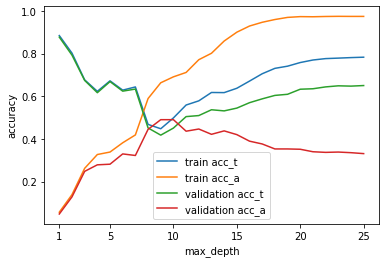

In [18]:
# Візуалізація отриманих результатів
import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

In [19]:
# Знайдемо оптимальну глибину дерева (для якого отримана найвища точність виявлення аритмії на валідаційному наборі даних)
opimal_max_depth = depth_range[np.where(val_acc_a==np.max(val_acc_a))[0][0]]
print('Оптимальна глибина дерева (max_depth): {}'.format(opimal_max_depth))
print('Значення точності (аритмія, валідаційний набір): {}'.format(val_acc_a[opimal_max_depth]))
print('Значення точності (загальна, валідаційний набір): {}'.format(val_acc_t[opimal_max_depth]))

Оптимальна глибина дерева (max_depth): 9
Значення точності (аритмія, валідаційний набір): 0.4905109489051095
Значення точності (загальна, валідаційний набір): 0.45119738751814226


### Повторне навчання моделі з використанням знайденої оптимальної глибини дерева

In [20]:
# Ініціалізація моделі Decision Tree Classifier (з балансуванням даних)
dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=opimal_max_depth)

# Навчання моделі на навчальному наборі даних (X_train, y_train)
dtc.fit(X_train, y_train)

# Отримання прогнозів (класів захворювань) за тестовим набором даних (X_test)
y_pred = dtc.predict(X_test)

# Оцінка якості моделі за тестовим набором даних (y_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_A maximized')

-----------------------------------
DT: Acc_A maximized
Загальна точність, Acc_T = 0.4164
Точність прогнозу за класом Аритмії, Acc_A = 0.4769
-----------------------------------


### Отримання прогнозів моделі на випадково вибраних сигналах із валідаційного набору даних

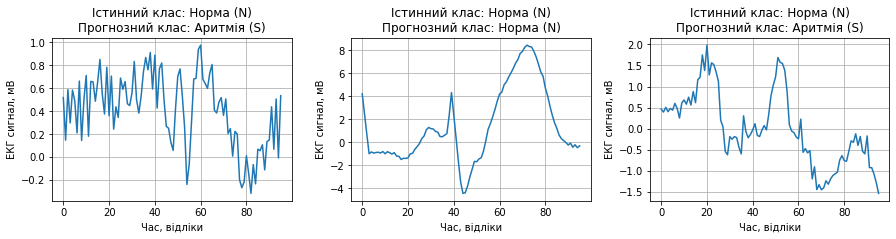

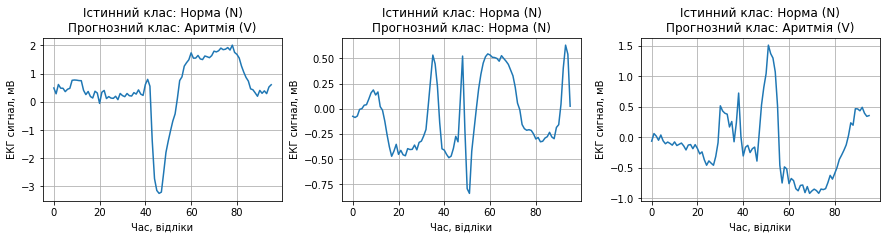

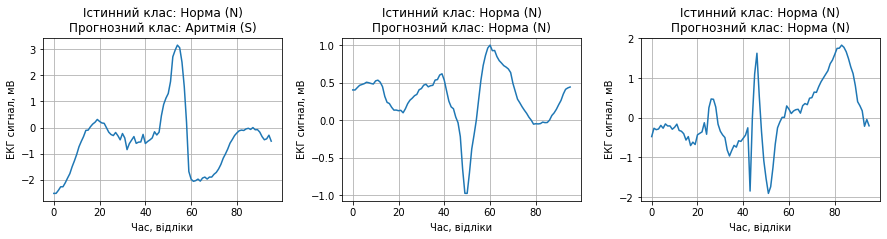

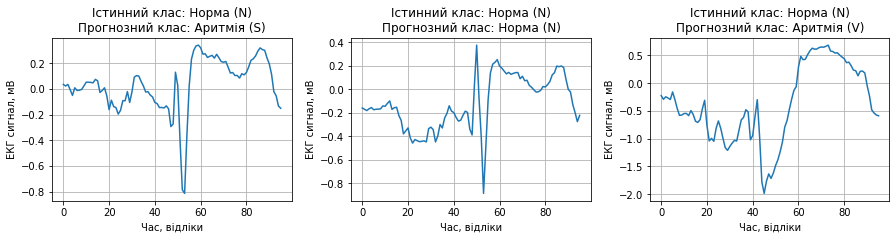

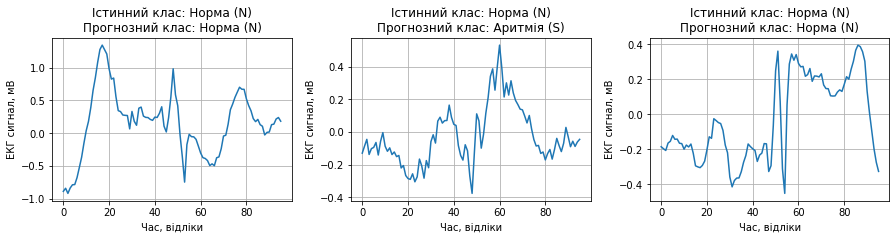

In [21]:
# Виберемо випадковим чином 15 сигналів, що належать до класу N" (нормальний ритм)
# і спробуємо отримати для них прогнози від побудованої моделі 
number_of_samples = 15
n_idx = np.where(y_val=='N')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів, а також прогнози класів на графіках
for i in range(5):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    # Отримання прогнозів (класів захворювань) 
    y_pred = dtc.predict(X_val[sample_number[i,:]])

    for j, sn in enumerate(sample_number[i,:]):
        if y_val[sn] == 'N':
            y_val_text = 'Норма ' + '(' + y_val[sn] + ')'
        else:
            y_val_text = 'Аритмія ' + '(' + y_val[sn] + ')'

        if y_pred[j] == 'N':
            y_pred_text = 'Норма ' + '(' + y_pred[j] + ')'
        else:
            y_pred_text = 'Аритмія ' + '(' + y_pred[j] + ')'        

        ax[j].plot(X_val[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='Істинний клас: ' +  y_val_text + '\n' 
                  'Прогнозний клас: ' + y_pred_text) 
        ax[j].grid()
    plt.show()

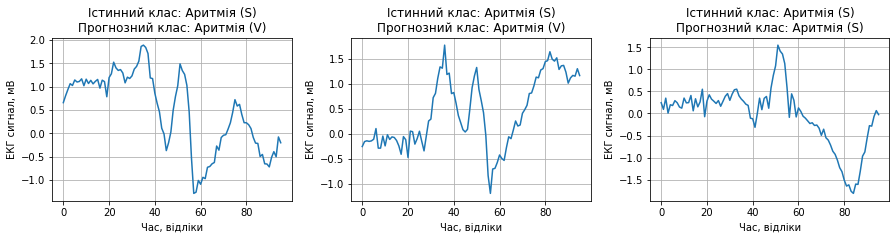

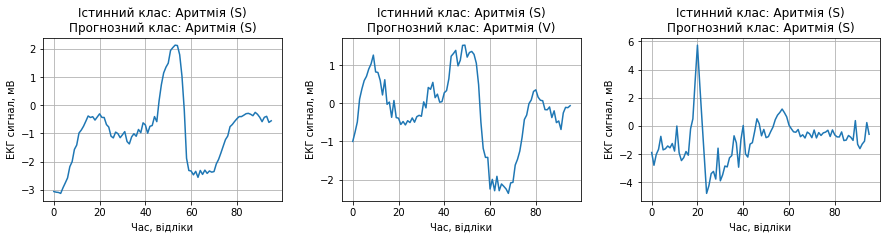

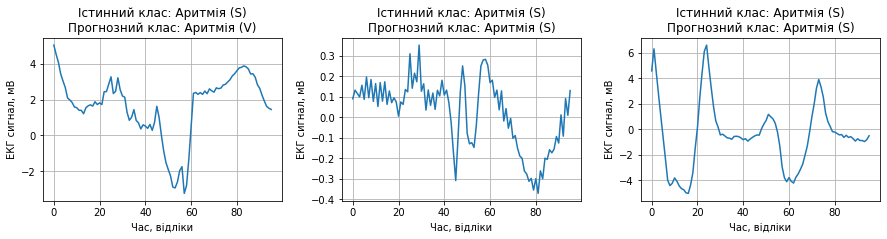

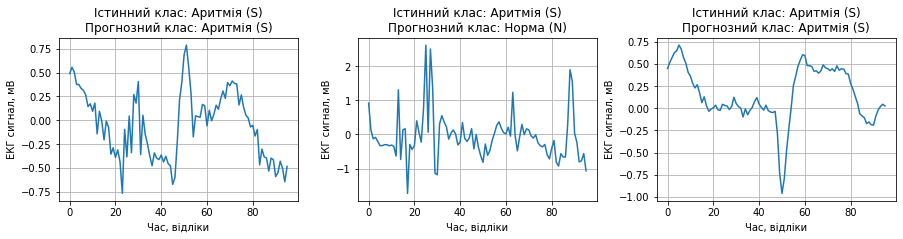

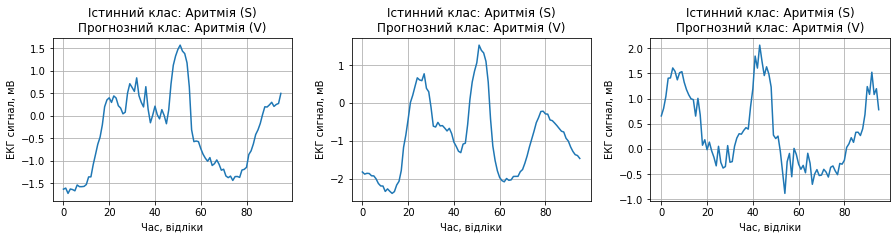

In [22]:
# Виберемо випадковим чином 15 сигналів, що належать до класу S" (аритмія)
# і спробуємо отримати для них прогнози від побудованої моделі 
number_of_samples = 15
n_idx = np.where(y_val=='S')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів, а також прогнози класів на графіках
for i in range(5):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    # Отримання прогнозів (класів захворювань)
    y_pred = dtc.predict(X_val[sample_number[i,:]])  

    for j, sn in enumerate(sample_number[i,:]):
        if y_val[sn] == 'N':
            y_val_text = 'Норма ' + '(' + y_val[sn] + ')'
        else:
            y_val_text = 'Аритмія ' + '(' + y_val[sn] + ')'

        if y_pred[j] == 'N':
            y_pred_text = 'Норма ' + '(' + y_pred[j] + ')'
        else:
            y_pred_text = 'Аритмія ' + '(' + y_pred[j] + ')'        

        ax[j].plot(X_val[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='Істинний клас: ' +  y_val_text + '\n' 
                  'Прогнозний клас: ' + y_pred_text) 
        ax[j].grid()
    plt.show()

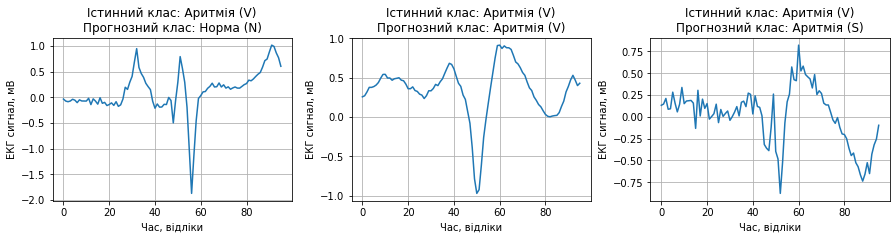

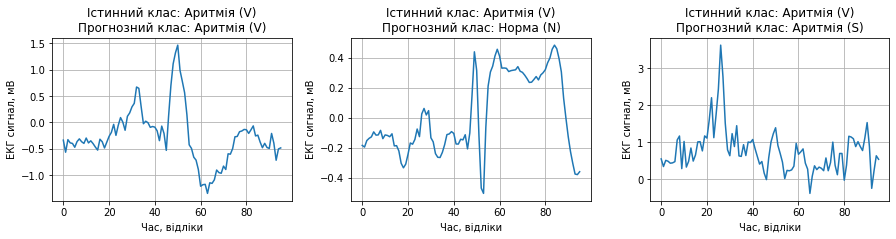

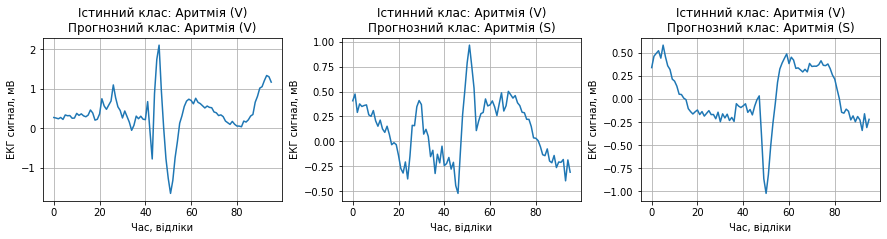

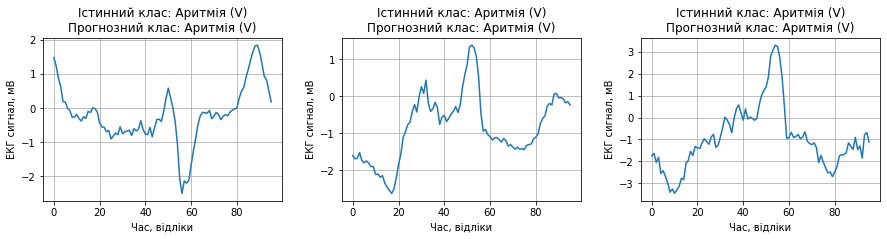

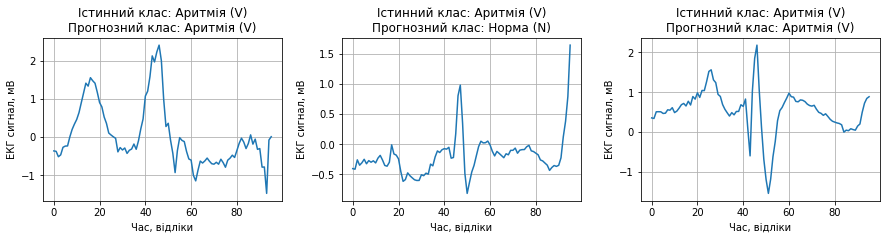

In [23]:
# Виберемо випадковим чином 15 сигналів, що належать до класу V" (аритмія)
# і спробуємо отримати для них прогнози від побудованої моделі 
number_of_samples = 15
n_idx = np.where(y_val=='V')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів, а також прогнози класів на графіках
for i in range(5):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    # Отримання прогнозів (класів захворювань) 
    y_pred = dtc.predict(X_val[sample_number[i,:]])  

    for j, sn in enumerate(sample_number[i,:]):
        if y_val[sn] == 'N':
            y_val_text = 'Норма ' + '(' + y_val[sn] + ')'
        else:
            y_val_text = 'Аритмія ' + '(' + y_val[sn] + ')'

        if y_pred[j] == 'N':
            y_pred_text = 'Норма ' + '(' + y_pred[j] + ')'
        else:
            y_pred_text = 'Аритмія ' + '(' + y_pred[j] + ')'        

        ax[j].plot(X_val[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='Істинний клас: ' +  y_val_text + '\n' 
                  'Прогнозний клас: ' + y_pred_text) 
        ax[j].grid()
    plt.show()

### Повторне навчання моделі з використанням заданих користувачем параметрів

In [24]:
# Задаємо значення гіперпараметрів моделі
min_samples_leaf = 10
max_depth = 13

# Ініціалізація моделі Decision Tree Classifier (з балансуванням даних)
dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=min_samples_leaf,
                             max_depth=max_depth)

# Навчання моделі на навчальному наборі даних (X_train, y_train)
dtc.fit(X_train, y_train)

# Отримання прогнозів (класів захворювань) за тестовим набором даних (X_test)
y_pred = dtc.predict(X_test)

# Оцінка якості моделі за тестовим набором даних (y_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_T + Acc_A maximized')

-----------------------------------
DT: Acc_T + Acc_A maximized
Загальна точність, Acc_T = 0.5290
Точність прогнозу за класом Аритмії, Acc_A = 0.4292
-----------------------------------


### Отримання прогнозів моделі на випадково вибраних сигналах із валідаційного набору даних

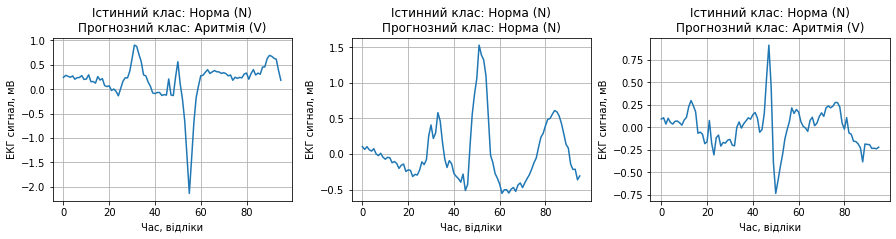

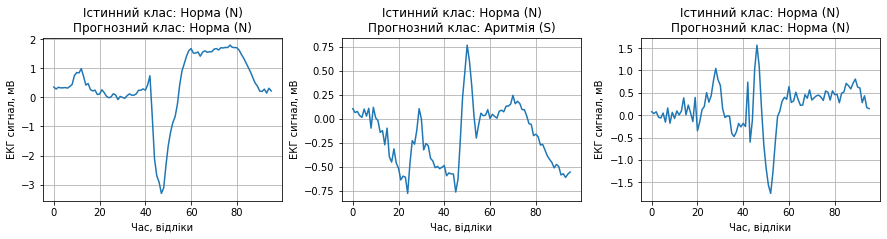

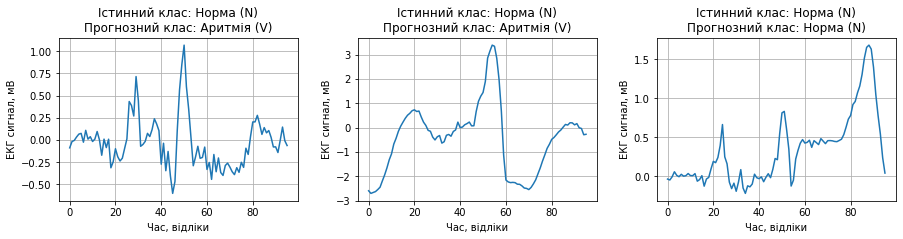

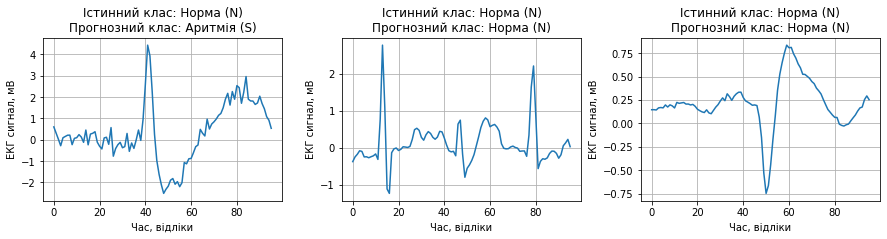

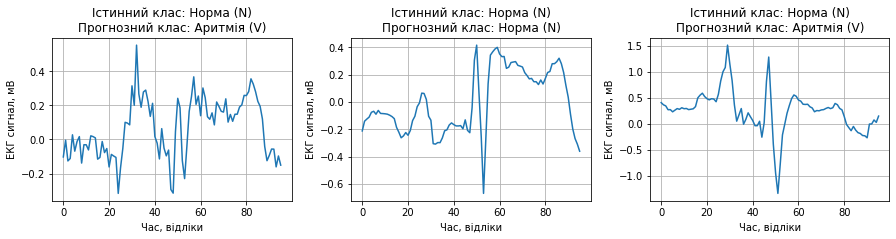

In [25]:
# Виберемо випадковим чином 15 сигналів, що належать до класу N" (нормальний ритм)
# і спробуємо отримати для них прогнози від побудованої моделі 
number_of_samples = 15
n_idx = np.where(y_val=='N')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів, а також прогнози класів на графіках
for i in range(5):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    # Отримання прогнозів (класів захворювань) 
    y_pred = dtc.predict(X_val[sample_number[i,:]])  

    for j, sn in enumerate(sample_number[i,:]):
        if y_val[sn] == 'N':
            y_val_text = 'Норма ' + '(' + y_val[sn] + ')'
        else:
            y_val_text = 'Аритмія ' + '(' + y_val[sn] + ')'

        if y_pred[j] == 'N':
            y_pred_text = 'Норма ' + '(' + y_pred[j] + ')'
        else:
            y_pred_text = 'Аритмія ' + '(' + y_pred[j] + ')'        

        ax[j].plot(X_val[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='Істинний клас: ' +  y_val_text + '\n' 
                  'Прогнозний клас: ' + y_pred_text) 
        ax[j].grid()
    plt.show()

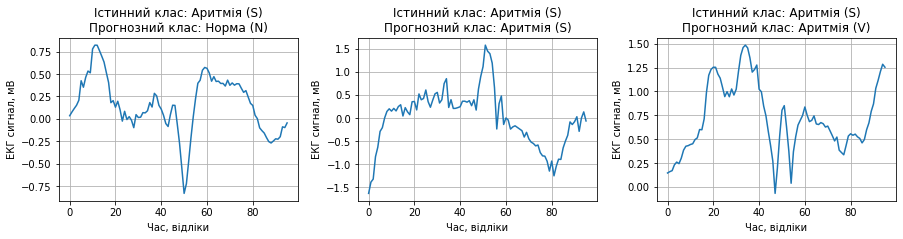

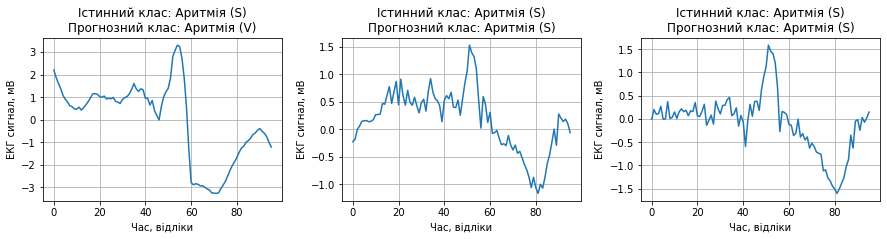

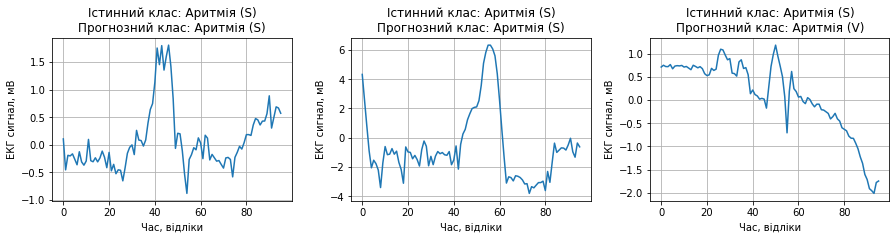

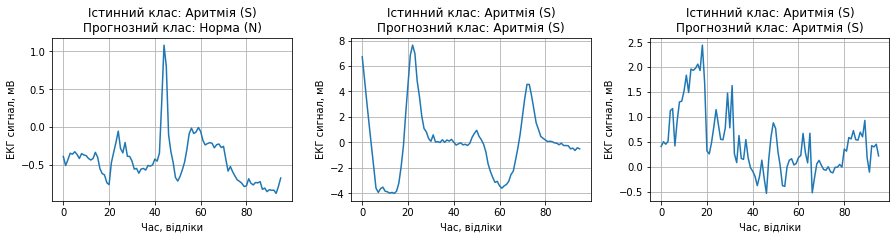

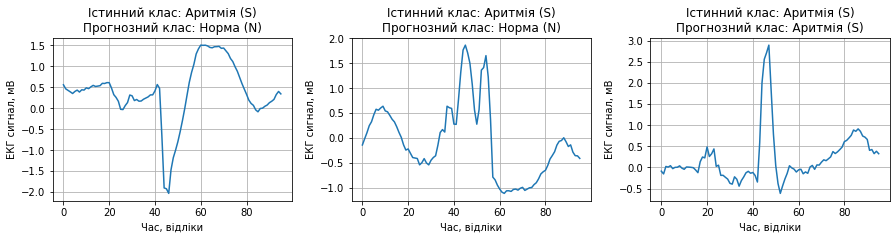

In [26]:
# Виберемо випадковим чином 15 сигналів, що належать до класу S" (аритмія)
# і спробуємо отримати для них прогнози від побудованої моделі 
number_of_samples = 15
n_idx = np.where(y_val=='S')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів, а також прогнози класів на графіках
for i in range(5):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    # Отримання прогнозів (класів захворювань) 
    y_pred = dtc.predict(X_val[sample_number[i,:]])  

    for j, sn in enumerate(sample_number[i,:]):
        if y_val[sn] == 'N':
            y_val_text = 'Норма ' + '(' + y_val[sn] + ')'
        else:
            y_val_text = 'Аритмія ' + '(' + y_val[sn] + ')'

        if y_pred[j] == 'N':
            y_pred_text = 'Норма ' + '(' + y_pred[j] + ')'
        else:
            y_pred_text = 'Аритмія ' + '(' + y_pred[j] + ')'        

        ax[j].plot(X_val[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='Істинний клас: ' +  y_val_text + '\n' 
                  'Прогнозний клас: ' + y_pred_text) 
        ax[j].grid()
    plt.show()

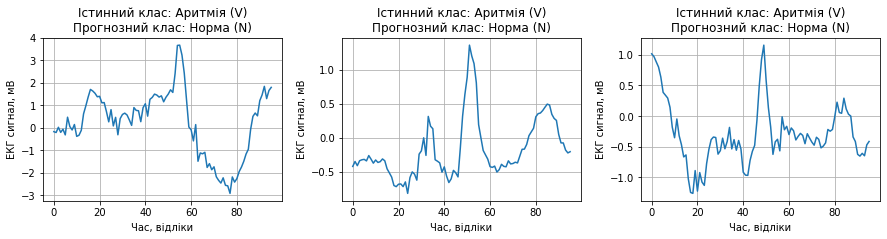

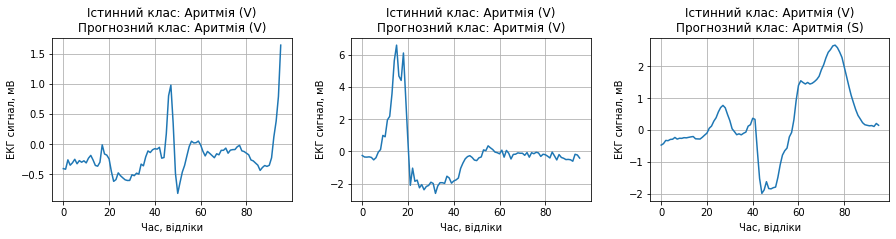

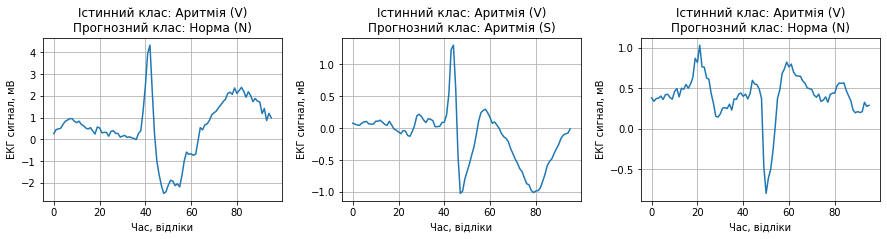

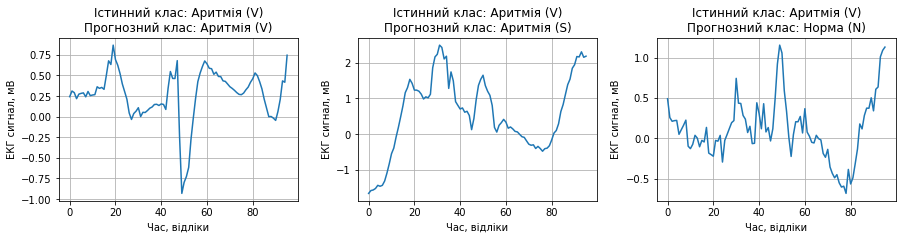

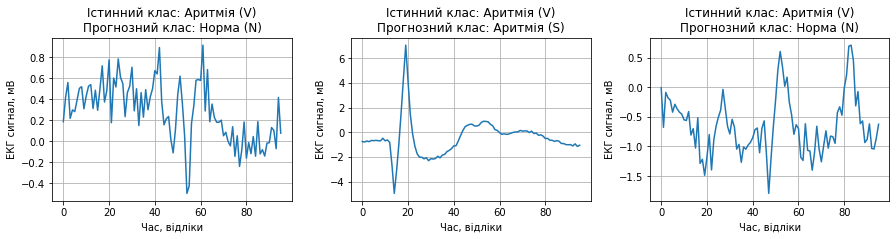

In [27]:
# Виберемо випадковим чином 15 сигналів, що належать до класу V" (аритмія)
# і спробуємо отримати для них прогнози від побудованої моделі 
number_of_samples = 15
n_idx = np.where(y_val=='V')[0]
sample_number = n_idx[sample_without_replacement(len(n_idx), number_of_samples)]
sample_number = np.reshape(sample_number, [5, 3])

# Відобразимо зразки сигналів, а також прогнози класів на графіках
for i in range(5):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 3)
    plt.subplots_adjust(wspace=0.25)

    # Отримання прогнозів (класів захворювань) 
    y_pred = dtc.predict(X_val[sample_number[i,:]])  

    for j, sn in enumerate(sample_number[i,:]):
        if y_val[sn] == 'N':
            y_val_text = 'Норма ' + '(' + y_val[sn] + ')'
        else:
            y_val_text = 'Аритмія ' + '(' + y_val[sn] + ')'

        if y_pred[j] == 'N':
            y_pred_text = 'Норма ' + '(' + y_pred[j] + ')'
        else:
            y_pred_text = 'Аритмія ' + '(' + y_pred[j] + ')'        

        ax[j].plot(X_val[sn])
        ax[j].set(xlabel='Час, відліки', ylabel='ЕКГ сигнал, мВ', title='Істинний клас: ' +  y_val_text + '\n' 
                  'Прогнозний клас: ' + y_pred_text) 
        ax[j].grid()
    plt.show()

Висновок:
Дерево рішень працює трохи гірше (ніж SVM) і має тенденцію до перенавчання. Ми розглядаємо два типи гіперпараметрів:
max_depth, min_samples_leaf.
Налаштування max_depth дає максимальне значення Acc_A (max_depth=8), або Acc_T & Acc_A (max_depth=13)
Дайте пояснення побудованого графіку точностей для тестової та валідаційних наборів даних.

# Завдання для виконання
Виконайте наступні завдання:
1. Модифікуйте класифікатор, шляхом підбору показника max_depth (глибина дерева (або кількість шарів дерева)) у виразі = range(1,26) потрібно  замість 26 змінювати в діапазоні від 2 до 50 для Підвищення якості класифікаційної моделі Дерев рішень (DT)  max_depth= ) щоб отримати найвищу точність для Acc_T та Acc_A
2. Кожен етап експерименту внесіть в протокол Гугл таблиці де вкажіть точності Загальної та за класом Аритмії, Acc_T = ..........., Acc_A =....... Також додайте отриманий графік. Після кожного проведеного експеременту дайте пояснення побудованого графіку точностей для тестової та валідаційних наборів даних. Проведіть не менше 5 експериментів і зробіть висновок, щодо накращих значень max_depth (глибина дерева (або кількість рівнів дерева)) і поясніть чому.
